In [71]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import sqlite3
import re
from collections import defaultdict

# Length after run for it to end
event_horizon = 10
# Average margin for a game that prevents blowouts from being counted
max_average_margin = 10

def read_dictionary(filename):
    """
    Opens the indicated filename and creates a list line by line using the first entry on each line
    as the key and the second as the value
    """
    dictionaryoutput = {}
    with open(filename) as file:
        entries = csv.reader(file)
        for item in entries:
            dictionaryoutput[item[0]] = item[1]
    return dictionaryoutput

def write_dict(outputfilename, dictionary):
    """
    Writes a dictionary to a csv.
    """
    # May want to modify this code to pickle the key and value and alter the read dictionary to do the same.

    with open(outputfilename, 'w', newline='') as outfile:
        for key, value in dictionary.items():
            outfile.write('%s,%s\n' % (key, value))
            
def write_list(outputfilename, list):
    """
    Writes a list to a csv.
    """
    with open(outputfilename, 'w', newline='') as outfile:
        itemwriter = csv.writer(outfile, delimiter=",")
        for item in list:
            itemwriter.writerow(item)
            
def read_list(filename):
    """
    Opens the indicated filename and creates a list line by line
    """
    listoutput = []
    with open(filename) as file:
        entries = csv.reader(file)
        for item in entries:
            listoutput.append(item)
    return listoutput

ABRDict = read_dictionary('C:\\Dropbox\\Dropbox\\HAXz\\CBBTO\\espn_scraper\\ABRdictionary.csv')
NUMDict = read_dictionary('C:\\Dropbox\\Dropbox\\HAXz\\CBBTO\\espn_scraper\\NUMdictionary.csv')


In [2]:
conn = sqlite3.connect('C:\\Dropbox\\Dropbox\\HAXz\\CBBTO\\data\\CBBdb.sqlite3')
curr = conn.cursor()

# Exclude unused events and corrupted data
data = pd.read_sql_query("""SELECT rowid,*
                        FROM playbyplay
                        WHERE game_id not in ('253240066', '253510006', '260692440', '283190221',
                        '283192166', '283190201', '293170264', '283342390', '293172633', 303172239, 290450275,
                        280472483, 283472390, 290450275, 290650087, 293170041, 260280218, 263240150, 270170222,
                        400498526, 400591228, 273332603, 310630171)""", conn)

conn.close()

# Ensure that numbers are numeric values and not strings.
data = data.apply(pd.to_numeric,errors='ignore')


In [3]:
data.head()

,rowid,game_id,date,event_index,time,actor,event,away,home,away_score,home_score
0,1,253120183,2005-11-09,0,1194,183,Darryl Watkins missed Two Point Layup.,BCU,SYR,0,0
1,2,253120183,2005-11-09,1,1176,183,Louie McCroskey made Three Point Jumper.,BCU,SYR,0,3
2,3,253120183,2005-11-09,2,1154,2065,Cleveland Williams missed Two Point Jumper.,BCU,SYR,0,3
3,4,253120183,2005-11-09,3,1154,183,Demetris Nichols Defensive Rebound.,BCU,SYR,0,3
4,5,253120183,2005-11-09,4,1146,183,Demetris Nichols made Three Point Jumper.,BCU,SYR,0,6


In [4]:
# We need to divide games into periods so that we don't span halftime,
# overtime periods or different games. Separating games into periods ensures
# that clock behavior is consistent and that score differentials are not
# calculated across periods or games.

# Add each half/ot to periods list
periods = []
lastindex = 0
lasttime = data.iloc[0]['time']
for i, row in data.iterrows():
    time = row['time']
    if time > lasttime + 1:
        period = data[lastindex:i]
        period['game_id'].values[0]
        periods.append(data[lastindex:i])
        lastindex = i
    lasttime = time
    
#Add the last period
periods.append(data[lastindex:i])

In [69]:
game_sequences = []
last_game_id = -1
for period in periods:
    game_id = period.game_id.values[0]
    # Should be O(n) https://stackoverflow.com/questions/4435169/good-way-to-append-to-a-string
    game_sequence = ''
    # We carry the halftime/overtime score and reset on a new game 
    if game_id != last_game_id:
        last_home = 0
        last_away = 0
    for i,row in period.iterrows():
        # Excluding last 90 seconds
        if row.time < 90:
            break
        points = (row.home_score - last_home) - (row.away_score - last_away)
        last_home = row.home_score
        last_away = row.away_score

        if 'timeout' in row.event.lower():
            if 'tv' in row.event.lower():
                game_sequence += 'OT'
            if row.actor != -1:              
                if NUMDict[str(row.actor)] in ABRDict[row.home]:
                    game_sequence += 'HT'
                elif NUMDict[str(row.actor)] in ABRDict[row.away]:
                    game_sequence += 'AT'
            else:
                 game_sequence += 'UT'
        elif points > 0:
            game_sequence += 'H' + str(points)
        elif points < 0: 
            game_sequence += 'A' + str(abs(points))
    last_game_id = game_id
    last_home = period.iloc[-1].home_score
    last_away = period.iloc[-1].away_score
            
    game_sequences.append([game_id, game_sequence])


print(game_sequences[123])


[253300277, 'A2H2A2H2A1A1HT']


In [59]:
#write_list('game_sequences.csv', game_sequences)

In [85]:
run_dictionary = defaultdict(list)
for period in game_sequences:       
    for start,end in [(m.start(0), m.end(0)) for m in re.finditer(r"H[2-3][H1-3]+AT", period[1])]:
        run = period[1][start:end]
        sequence = period[1][end:end+8]
        try:
            run_dictionary[run].append(sequence)
        except:
            run_dictionary[run] = [sequence]
    for end in [m.end(0) for m in re.finditer(r"A[2-3][A1-3]+HT", period[1])]:
        run =  period[1][end-8:end]
        sequence = period[1][end:end+8]
        try:           
            run_dictionary[run].append(sequence)
        except:
            run_dictionary[run] = [sequence]

print(run_dictionary)

defaultdict(<class 'list'>, {'H2H2H1H1H3AT': ['A2OTHTH2', 'OTATA1A3', 'A1H2H2OT', 'H1H1A2H3'], 'ATA2A2HT': ['A2H1H1H2', 'H3', 'H2H2H2A2', 'H2H2OTAT', 'H2ATH1H1', 'H2H1A1A1', 'H2H2A2', 'H2H3A2OT', 'H2', 'OTHTH1H1', 'A1H2H1', 'A1A2H3OT', 'A2OTHTH1', 'H2', 'H2A2A2A1', 'H3OTHT', '', 'H2H2OTAT', 'OTHTH1H1', 'A2A2H2OT', 'OTATH2A2', 'A1H2A1A2', 'H2A2H3A2', 'A1', 'A1A1H2A3', 'H1H1H1A2', 'A2H1H1A2', 'H2A2H2OT', 'H2H2H1A2', 'OTHTH1H1', 'A2H2A2A3', 'H2A3A2H2', 'A1A1A2OT', 'H1H1A2H2', 'H2H2A1OT', 'A2OTATH3', 'H2A2H2AT', 'A3H1H1A1', 'HTH2A2OT', 'H2A2H3OT', 'A1A2H1H1', 'HTH2OTAT', 'H2H2OTHT', 'H1H1ATH3', 'A2H3OTHT', 'A1A1A2H2', 'H2H1H1H1', 'ATH2OTAT', 'H2H1A2A2', 'H3A2OTHT', 'OTHTH3A2', 'A1A1A2A1', 'A3H1A3OT', 'H3H2A3OT', 'ATOTATA1', 'A2OTHTA2', 'H3A2A2OT', 'H2A2H1H1', 'A1H2H1A2', 'H3', 'H2ATH2OT', 'OTATA1A1', 'OTHTHT', 'OTHTA2H2', 'A2H1H1OT', 'OTHTH1H1', 'H1A2H2H3', 'H2H2H2OT', 'A1A1HTA2', 'OTHTH1H1', 'H2H2OTHT', 'H2OTATA1', 'OTHTA1A1', 'A2A2HTOT', 'H1H1H3OT', 'A2A2A2H3', '', 'H3A2H2H2', 'H2A2H2A2'

In [91]:
score_histograms = []
for key in run_dictionary:
    run_value = 0
    for c in str(key):
        if c == 'T':
            continue
        elif c == 'A':
            sign = -1
        elif c == 'H':
            sign = 1
        else:
            run_value += sign * int(c)
    score_histograms.append([key, run_value])
    seq_values = []
    for seq in run_dictionary[key]:
        seq_value = 0
        for c in str(seq):
            if c in 'OUT':
                continue
            elif c == 'A':
                sign = -1
            elif c == 'H':
                sign = 1
            else:
                seq_value += sign * int(c)
        seq_values.append(seq_value)
    score_histograms[-1].append(seq_values)
        

    print(score_histograms)

[['H2H2H1H1H3AT', 9, [0, -4, 3, 3]]]
[['H2H2H1H1H3AT', 9, [0, -4, 3, 3]], ['ATA2A2HT', -4, [2, 3, 4, 4, 4, 1, 2, 3, 2, 2, 2, 0, -1, 2, -3, 3, 0, 4, 2, -2, 0, -2, 1, -1, -3, 1, -2, 2, 3, 2, -5, -1, -4, 2, 3, 1, 2, -2, 0, 3, -1, 2, 4, 5, 1, -2, 5, 2, -1, 1, 1, -5, -5, 2, -1, -4, -1, 2, 0, 3, 4, -2, 0, 0, 0, 2, 4, 6, -4, 2, 4, 1, -2, -4, 5, -3, 0, 5, 0, -2, 3, -1, 2, 2, 1, -3, 3, 1, 0, 4, 0, 2, 1, 0, 4, 6, 0, -1, 6, 0, 0, -1, 1, 2, 0, 0, -2, 1, 1, 4, 1, 3, -1, 3, 5, 2, 4, 6, 3, 0, 6, 0, 0, -1, 0, 2, -4, 0, -2, -2, 1, 2, -3, 3, 0, -2, -1, 0, 2, -2, 1, 2, 0, 2, 6, 5, -2, -7, 0, -2, -6, 3, 1, 2, -2, 3, 0, 2, 0, 3, -2, -2, 3, 6, -2, 2, -4]]]
[['H2H2H1H1H3AT', 9, [0, -4, 3, 3]], ['ATA2A2HT', -4, [2, 3, 4, 4, 4, 1, 2, 3, 2, 2, 2, 0, -1, 2, -3, 3, 0, 4, 2, -2, 0, -2, 1, -1, -3, 1, -2, 2, 3, 2, -5, -1, -4, 2, 3, 1, 2, -2, 0, 3, -1, 2, 4, 5, 1, -2, 5, 2, -1, 1, 1, -5, -5, 2, -1, -4, -1, 2, 0, 3, 4, -2, 0, 0, 0, 2, 4, 6, -4, 2, 4, 1, -2, -4, 5, -3, 0, 5, 0, -2, 3, -1, 2, 2, 1, -3, 3, 1, 0, 4, 0, 2,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


ValueError: invalid literal for int() with base 10: 'U'

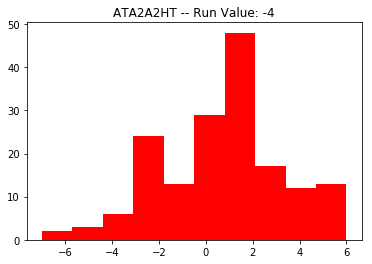

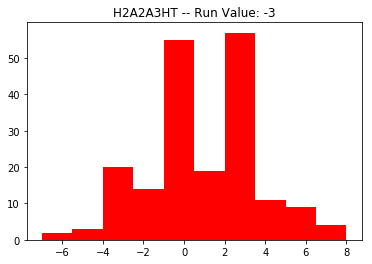

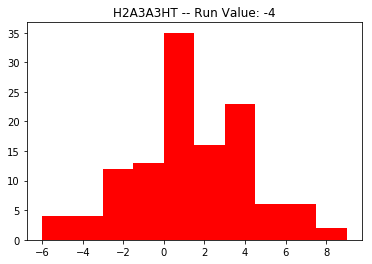

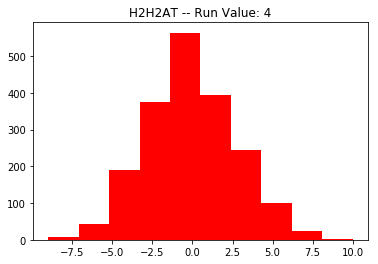

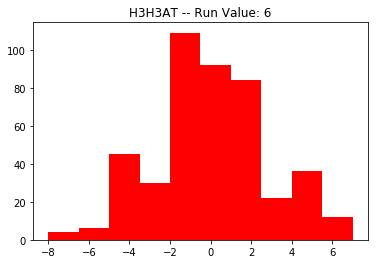

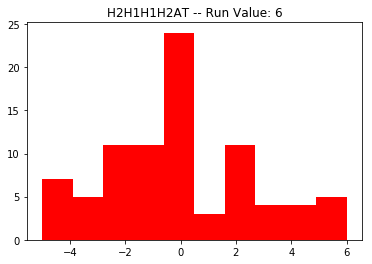

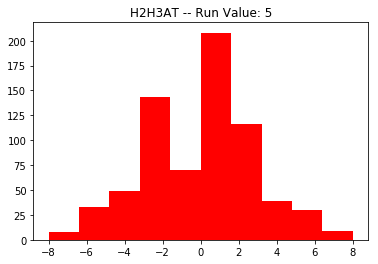

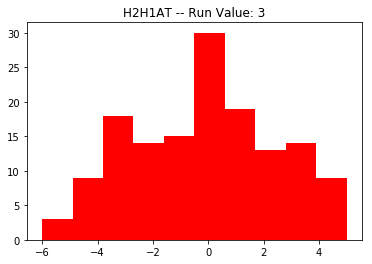

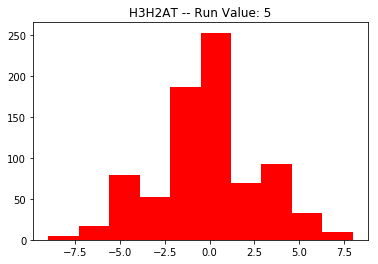

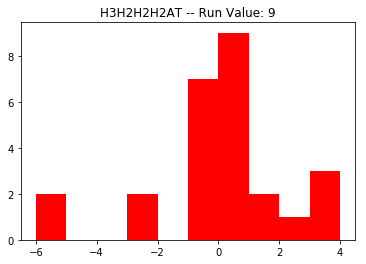

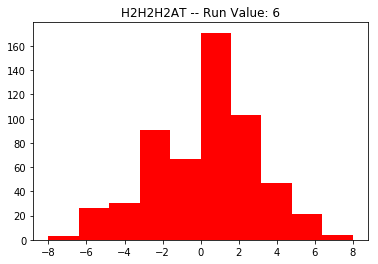

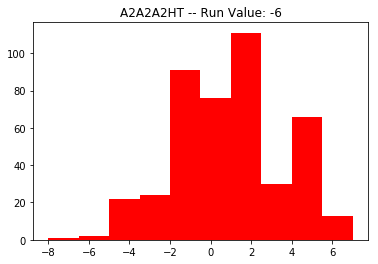

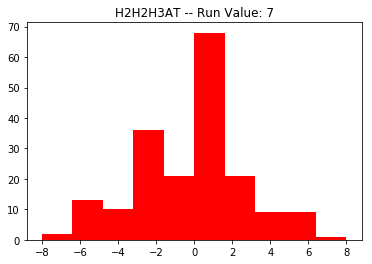

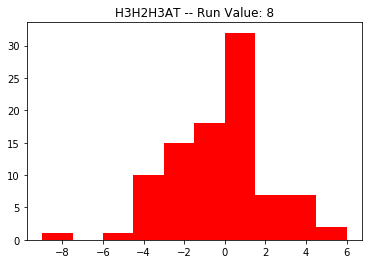

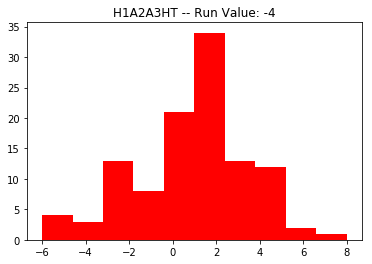

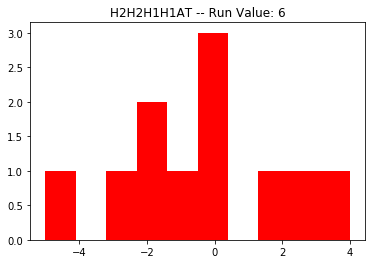

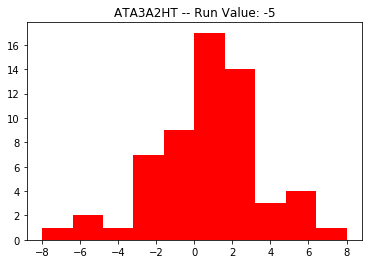

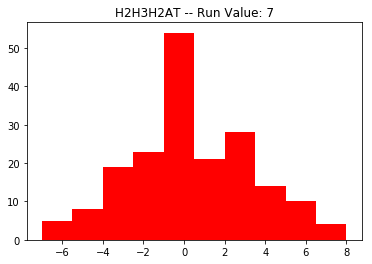

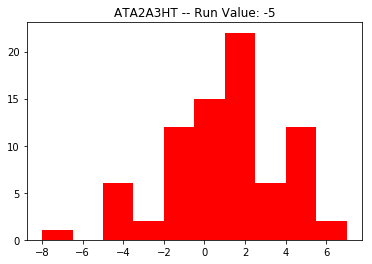

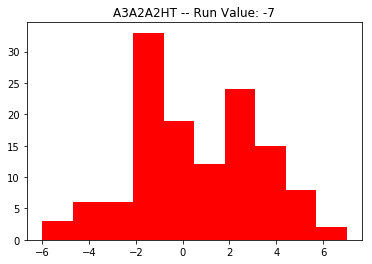

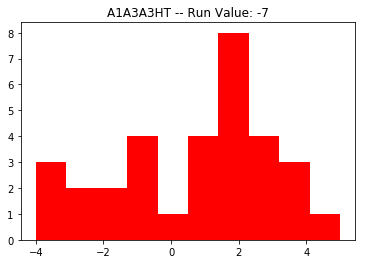

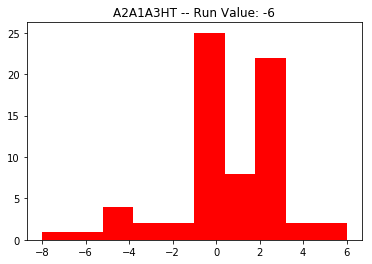

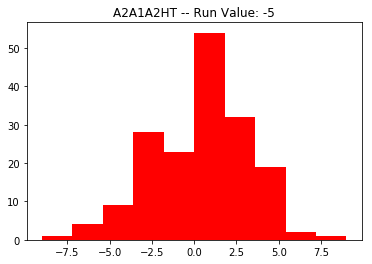

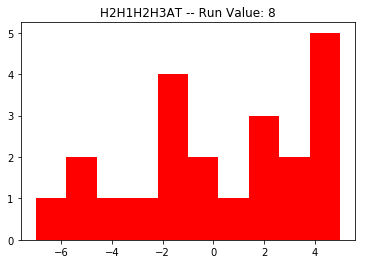

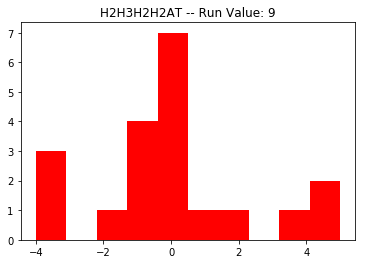

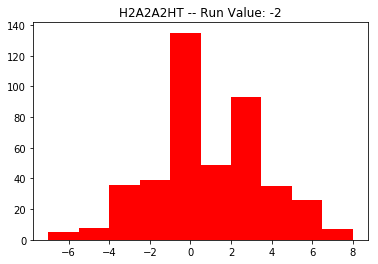

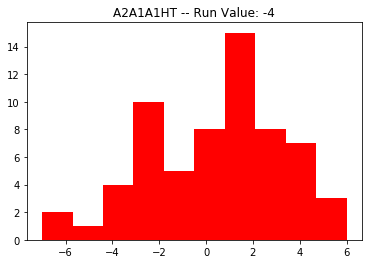

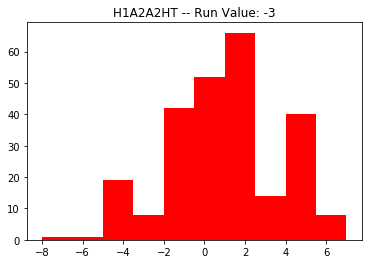

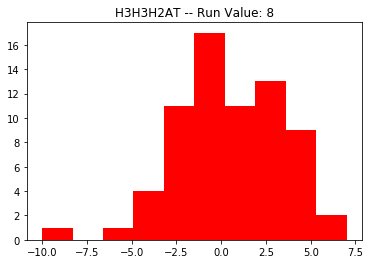

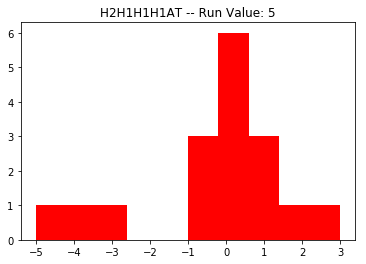

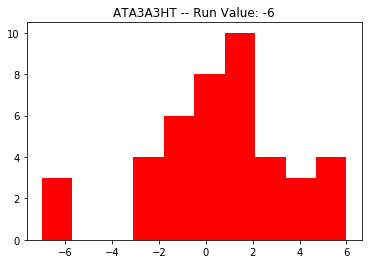

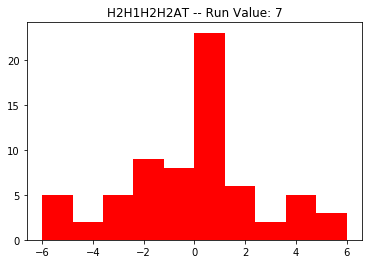

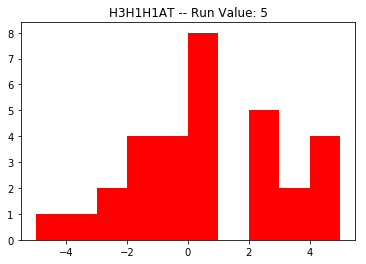

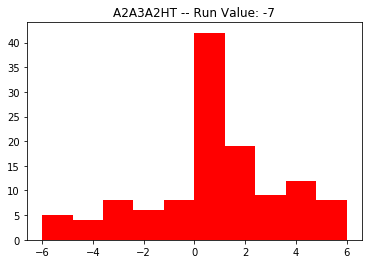

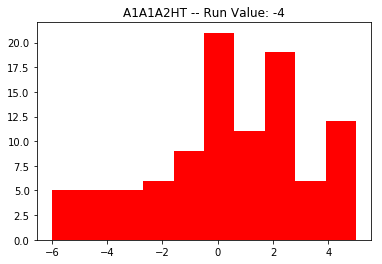

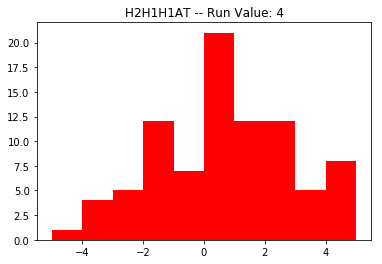

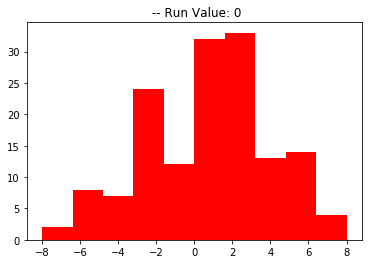

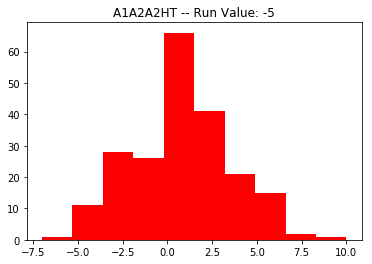

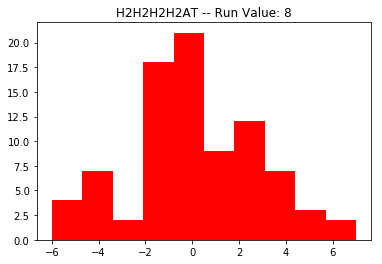

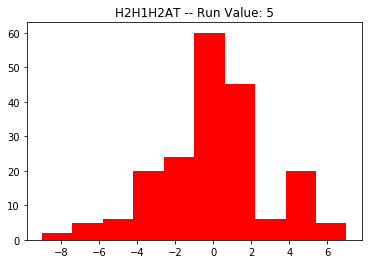

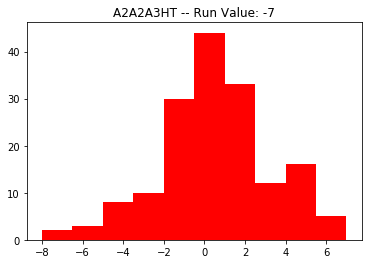

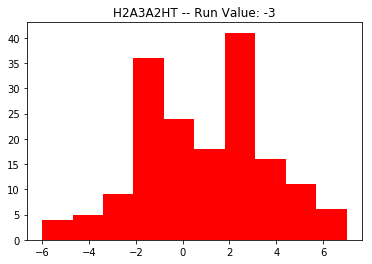

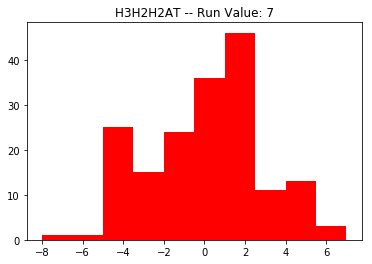

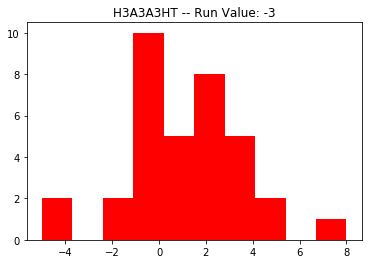

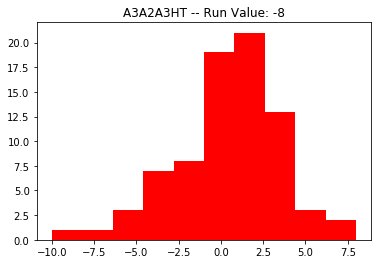

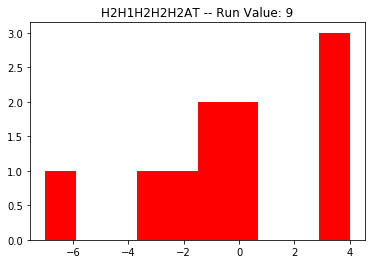

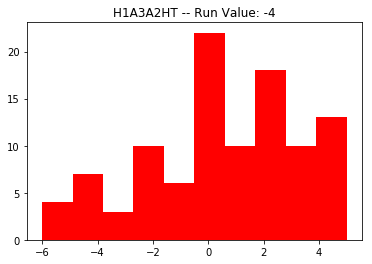

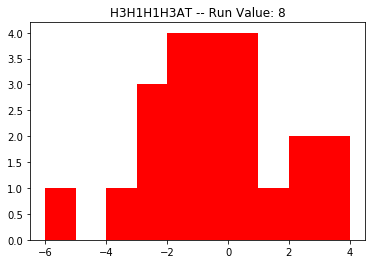

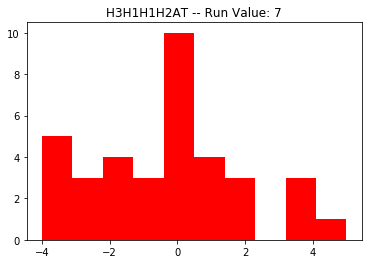

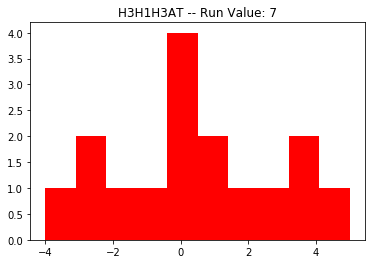

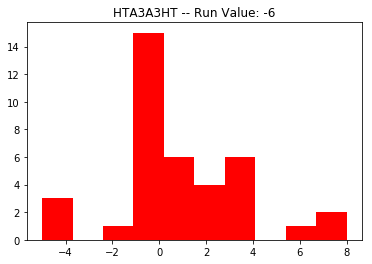

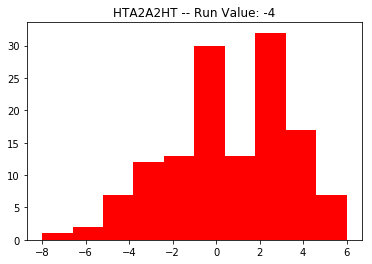

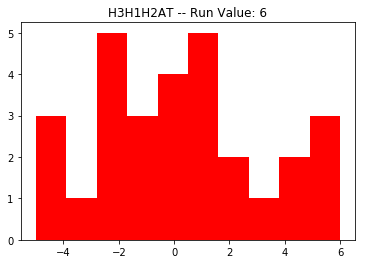

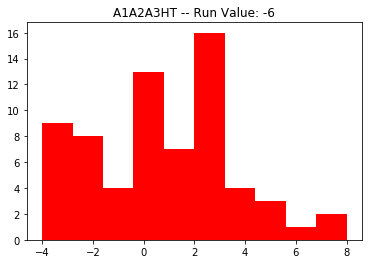

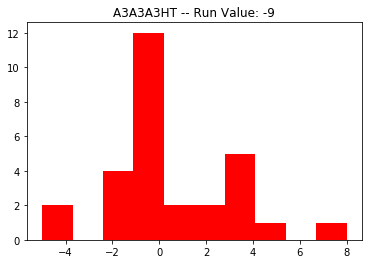

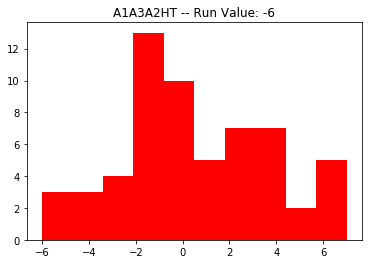

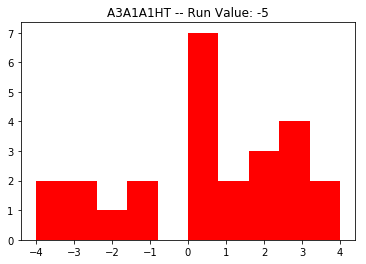

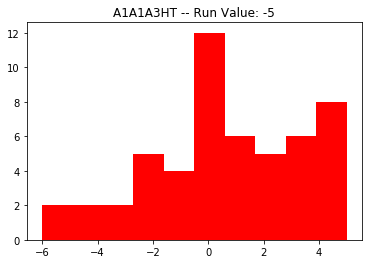

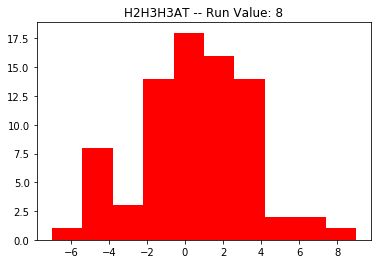

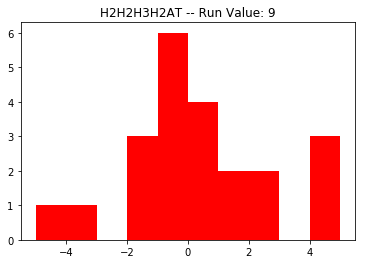

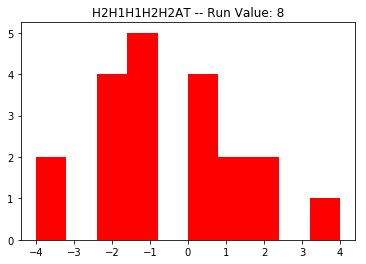

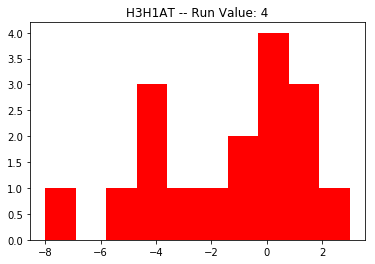

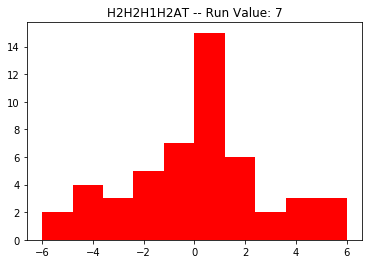

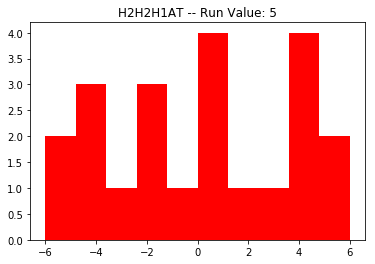

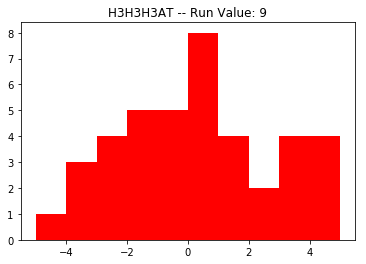

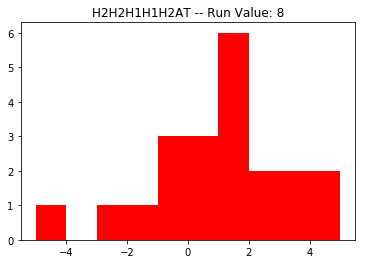

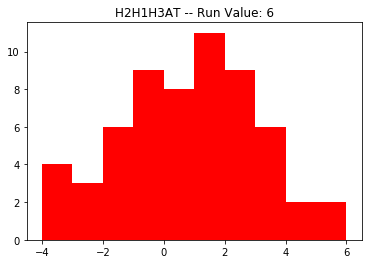

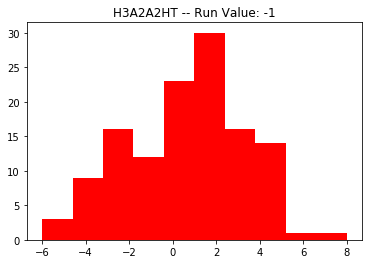

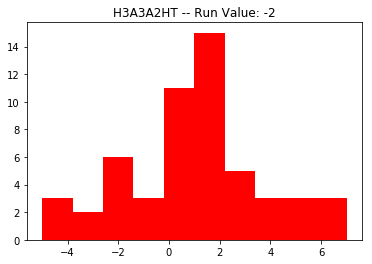

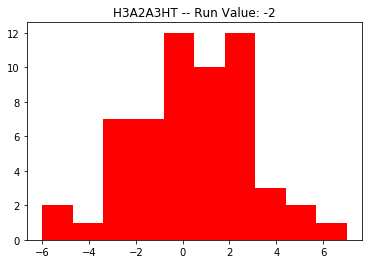

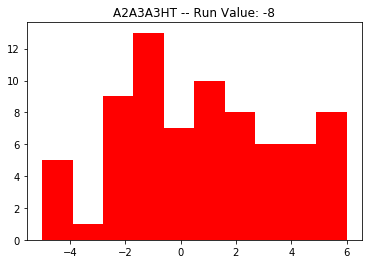

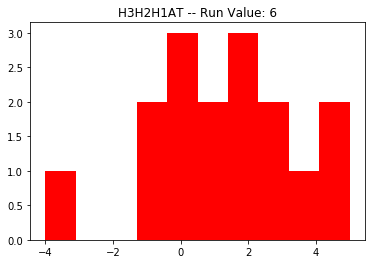

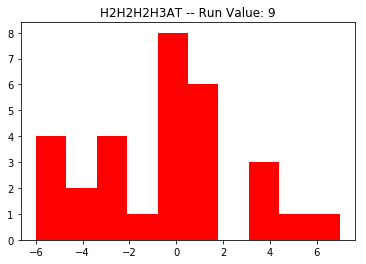

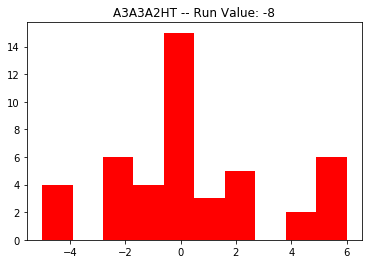

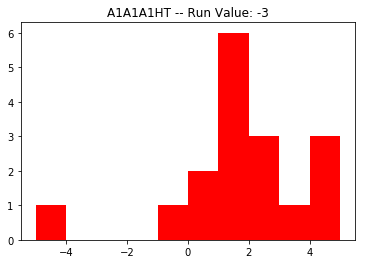

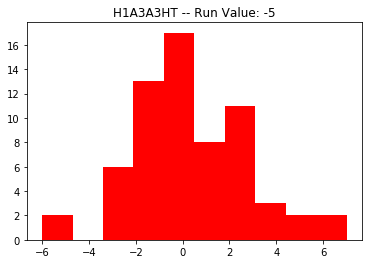

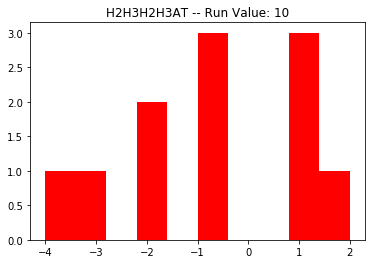

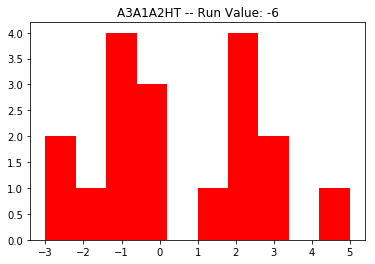

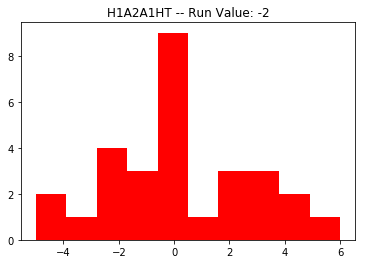

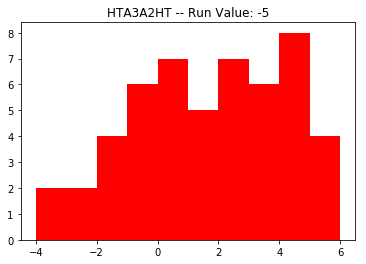

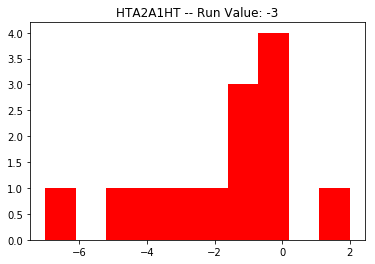

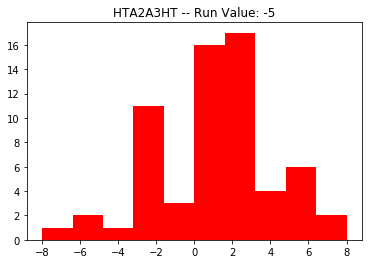

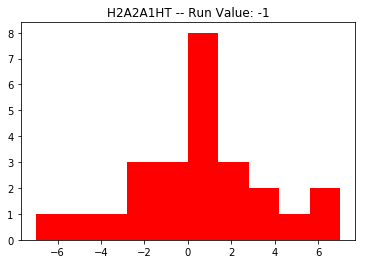

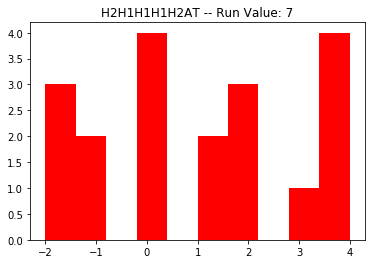

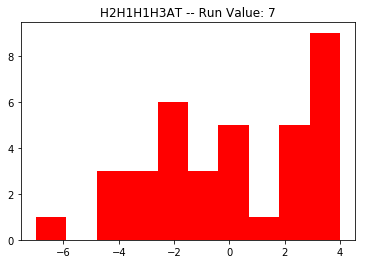

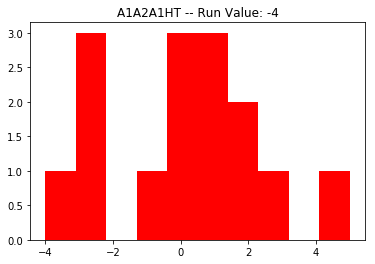

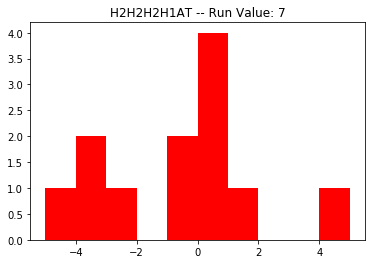

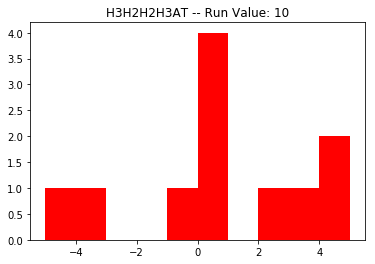

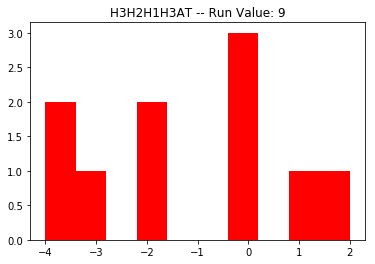

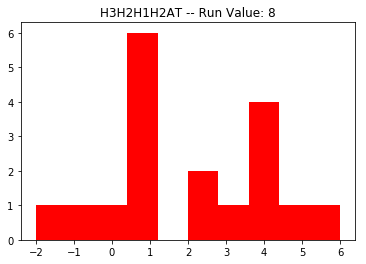

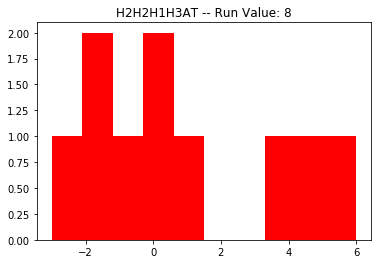

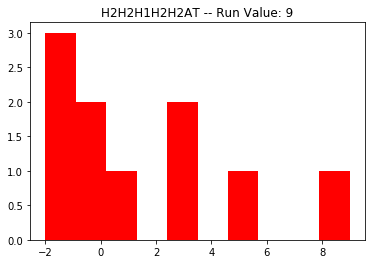

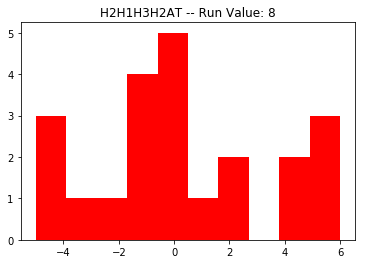

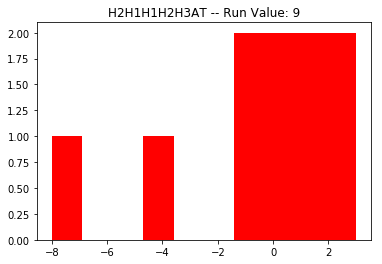

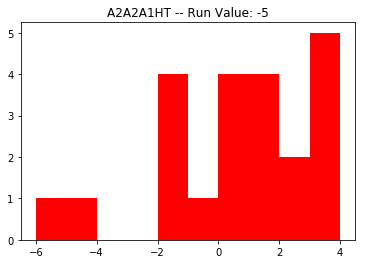

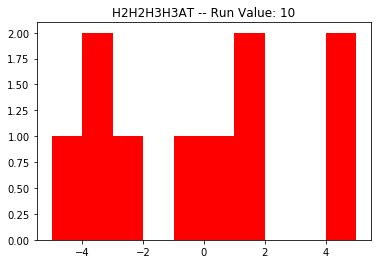

In [101]:
for gram in score_histograms:
    if len(gram[2]) < 10:
        continue
    plt.hist(gram[2], bins=10, color='r', alpha=1, label='diff')
    plt.title(gram[0] + ' -- Run Value: ' + str(gram[1]))
    plt.show()

In [21]:
#data.loc[(data.game_id == 253120183)]

In [7]:
# Nice little alert to let me know when the Notebook has finished
from IPython.display import HTML
HTML('''<script>
alert('Done!')
</script>''')